In [2]:
#Dependencies
import numpy as np
import pandas as pd
from pathlib import Path
from pycaret.nlp import *
from pycaret.classification import *

from sklearn.feature_extraction.text import CountVectorizer

In [63]:
df = pd.read_csv('data.csv')

In [65]:
pd.set_option('display.max_rows', 1000)

In [67]:
df['reviewText']

0      pretty good story, a little exaggerated, but I...
1      If you've read other max brand westerns, you k...
2                           Love Max, always a fun twist
3                          As usual for him, a good book
4      MB is one of the original western writers and ...
5                                             great book
6      A good, solid Western - yes, a little contrive...
7      ALMOST BEEN TOO LONG SINCE I READ IT. GOOD REA...
8      Enjoyed this book and will read more from this...
9      A very good read for you Western fans.  Great ...
10     Most of the New Jedi Order books focus on the ...
11     I was hoping to find this one in book form. Th...
12     Books are supposed to be made of paper and ink...
13     The events of "Ylesia" take place during "Dest...
14     With Ylesia, a novella originally published in...
15     I wasn't prepared for this to be short stories...
16     Louis L'Amour is a writer I've enjoyed since m...
17     LAmour is one of the bes

In [4]:
#Convert a collection of text documents to a matrix of token counts.
#implements both tokenization and occurrence counting in a single class:

tf_vectorizer = CountVectorizer(max_features=800,stop_words={'english'}, ngram_range=(1,1))
#features = tf_vectorizer.fit_transform(df['reviewText'].apply(lambda features : np.str_(features)))
#features_df = pd.DataFrame(features.toarray(), columns=tf_vectorizer.get_feature_names())

#################################################


In [5]:
features = tf_vectorizer.fit_transform(df['reviewText'].apply(lambda features : np.str_(features)))

In [6]:
features_df = pd.DataFrame(features.toarray(), columns=tf_vectorizer.get_feature_names())


In [ ]:
print("Vocabulary: ", tf_vectorizer.vocabulary_)

In [8]:
features_df.head(5)

,19th,20th,abagnale,able,about,absolutely,academy,account,action,actual,actually,adventure,after,again,against,age,ago,all,allison,almost,alone,along,already,also,although,always,am,amazing,american,amount,an,and,anita,another,any,anyone,anything,are,argeneau,around,articles,as,at,attention,author,authors,available,away,back,bad,bank,based,battle,be,became,because,become,becomes,bed,been,before,begin,beginning,begins,behind,being,believe,bennie,best,better,between,big,birthday,bit,bite,black,bliss,blood,book,books,boring,both,bought,bourgeoisie,brennan,brief,bring,business,but,buy,by,call,came,can,cannot,capital,capitalism,capitalist,care,carrie,case,catch,cause,century,certainly,chance,chandler,change,chapter,chapters,character,characters,child,children,civil,class,classes,clear,clearly,cm_cr_arp_d_rvw_txt,collection,college,come,comes,coming,communism,communist,compelling,complete,completely,con,concept,content,control,copy,could,couldn,country,couple,course,cover,created,crime,critique,culture,danger,dark,data,daughter,day,days,dead,deal,death,decided,definitely,descriptions,despite,detail,details,detective,developed,development,dialogue,did,didn,diet,different,difficult,disappointed,division,do,does,doesn,doing,don,done,down,dp,dr,due,during,each,earlier,early,easily,easy,economic,economics,edition,either,else,emily,end,ending,engels,engine,enjoy,enjoyable,enjoyed,enough,entertaining,entire,equal,era,especially,essay,etc,etna,european,even,events,eventually,ever,every,everyone,everything,evil,exactly,example,excellent,except,exciting,existence,existing,expect,expected,experience,face,fact,fall,family,fan,far,fast,father,favorite,fbi,feel,feeling,feels,felt,female,fett,few,fiction,figure,finally,find,finds,...,productive,professor,proletariat,property,published,put,questions,quick,quickly,quite,rate,rates,rather,rating,re,read,reader,readers,reading,real,reality,really,reason,reasons,recommend,ref,relations,relationship,rest,return,review,reviews,revolution,rich,right,romance,romantic,rosato,said,same,sands,save,saved,say,saying,says,scenes,scottoline,second,section,see,seem,seemed,seems,seen,self,sense,series,set,several,sex,she,ship,short,should,shreve,side,sight,simple,simply,since,sister,slave,slow,small,so,social,society,some,someone,something,sometimes,somewhat,sort,source,south,sowell,space,speak,spoilers,stand,star,stars,start,started,starts,state,states,steam,still,stories,story,strong,style,subject,subscription,such,sure,suspense,system,take,takes,taking,tale,tassel,tell,tells,text,than,thanks,that,the,their,them,themselves,then,there,these,they,thing,things,think,thinking,this,thomas,those,though,thought,three,through,throughout,thus,tied,time,times,to,today,together,told,tony,too,took,trading,travel,trial,tribe,trilogy,true,truly,try,trying,turn,turns,twist,two,ultimately,under,understand,understanding,unfortunately,unique,until,up,upon,us,use,used,usually,utf8,value,vampire,vampires,van,various,vatta,ve,version,very,view,villain,volume,vong,wait,want,wanted,wants,war,was,wasn,way,ways,we,wealth,weight,well,went,were,what,when,where,whether,which,while,who,whole,whose,why,wife,will,wish,with,within,without,woman,women,won,wonderful,word,words,work,workers,working,works,world,worth,would,write,writer,writes,writing,written,wrong,wrote,year,years,yes,yet,you,young,your
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [9]:
df = pd.concat([features_df,df['actual_ratings']],axis=1)

In [10]:
df.head(5)

,19th,20th,abagnale,able,about,absolutely,academy,account,action,actual,actually,adventure,after,again,against,age,ago,all,allison,almost,alone,along,already,also,although,always,am,amazing,american,amount,an,and,anita,another,any,anyone,anything,are,argeneau,around,articles,as,at,attention,author,authors,available,away,back,bad,bank,based,battle,be,became,because,become,becomes,bed,been,before,begin,beginning,begins,behind,being,believe,bennie,best,better,between,big,birthday,bit,bite,black,bliss,blood,book,books,boring,both,bought,bourgeoisie,brennan,brief,bring,business,but,buy,by,call,came,can,cannot,capital,capitalism,capitalist,care,carrie,case,catch,cause,century,certainly,chance,chandler,change,chapter,chapters,character,characters,child,children,civil,class,classes,clear,clearly,cm_cr_arp_d_rvw_txt,collection,college,come,comes,coming,communism,communist,compelling,complete,completely,con,concept,content,control,copy,could,couldn,country,couple,course,cover,created,crime,critique,culture,danger,dark,data,daughter,day,days,dead,deal,death,decided,definitely,descriptions,despite,detail,details,detective,developed,development,dialogue,did,didn,diet,different,difficult,disappointed,division,do,does,doesn,doing,don,done,down,dp,dr,due,during,each,earlier,early,easily,easy,economic,economics,edition,either,else,emily,end,ending,engels,engine,enjoy,enjoyable,enjoyed,enough,entertaining,entire,equal,era,especially,essay,etc,etna,european,even,events,eventually,ever,every,everyone,everything,evil,exactly,example,excellent,except,exciting,existence,existing,expect,expected,experience,face,fact,fall,family,fan,far,fast,father,favorite,fbi,feel,feeling,feels,felt,female,fett,few,fiction,figure,finally,find,finds,...,professor,proletariat,property,published,put,questions,quick,quickly,quite,rate,rates,rather,rating,re,read,reader,readers,reading,real,reality,really,reason,reasons,recommend,ref,relations,relationship,rest,return,review,reviews,revolution,rich,right,romance,romantic,rosato,said,same,sands,save,saved,say,saying,says,scenes,scottoline,second,section,see,seem,seemed,seems,seen,self,sense,series,set,several,sex,she,ship,short,should,shreve,side,sight,simple,simply,since,sister,slave,slow,small,so,social,society,some,someone,something,sometimes,somewhat,sort,source,south,sowell,space,speak,spoilers,stand,star,stars,start,started,starts,state,states,steam,still,stories,story,strong,style,subject,subscription,such,sure,suspense,system,take,takes,taking,tale,tassel,tell,tells,text,than,thanks,that,the,their,them,themselves,then,there,these,they,thing,things,think,thinking,this,thomas,those,though,thought,three,through,throughout,thus,tied,time,times,to,today,together,told,tony,too,took,trading,travel,trial,tribe,trilogy,true,truly,try,trying,turn,turns,twist,two,ultimately,under,understand,understanding,unfortunately,unique,until,up,upon,us,use,used,usually,utf8,value,vampire,vampires,van,various,vatta,ve,version,very,view,villain,volume,vong,wait,want,wanted,wants,war,was,wasn,way,ways,we,wealth,weight,well,went,were,what,when,where,whether,which,while,who,whole,whose,why,wife,will,wish,with,within,without,woman,women,won,wonderful,word,words,work,workers,working,works,world,worth,would,write,writer,writes,writing,written,wrong,wrote,year,years,yes,yet,you,young,your,actual_ratings
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [11]:
new_df = df.drop(df.index[df['actual_ratings'] == 3])

In [12]:
new_df.loc[(df['actual_ratings'] == 4) | (new_df['actual_ratings'] == 5), 'derived_ratings'] = 'positive'
new_df.loc[(df['actual_ratings'] == 1) | (new_df['actual_ratings'] == 2), 'derived_ratings'] = 'negative'
new_df.drop(['actual_ratings'], axis=1, inplace=True)


In [13]:
#Shuffle your dataset 
new_shuffle_df = new_df.sample(frac=1)

# Define a size for your train set 
new_train_size = int(0.9 * len(new_df))

# Split your dataset 
new_train_df = new_shuffle_df[:new_train_size]
new_test_df  = new_shuffle_df[new_train_size:]

In [14]:
numerical_features = list(features_df.columns)
new_clf = setup(data = new_train_df, target = 'derived_ratings',numeric_features=numerical_features, use_gpu=True, silent=True)



#new_clf=setup(data=new_train_df,target='derived_ratings')

,Description,Value
0,session_id,6331
1,Target,derived_ratings
2,Target Type,Binary
3,Label Encoded,"negative: 0, positive: 1"
4,Original Data,"(751, 801)"
5,Missing Values,False
6,Numeric Features,800
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [15]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8609,0.7517,0.9866,0.8680,0.9234,0.1982,0.2520,1.0760
rf,Random Forest Classifier,0.8571,0.7311,0.9955,0.8589,0.9221,0.1106,0.1727,1.1480
dummy,Dummy Classifier,0.8495,0.5000,1.0000,0.8495,0.9186,0.0000,0.0000,0.0180
knn,K Neighbors Classifier,0.8475,0.6116,0.9910,0.8534,0.9170,0.0449,0.0682,0.9800
lightgbm,Light Gradient Boosting Machine,0.8456,0.7451,0.9753,0.8615,0.9147,0.1244,0.1519,2.3590
gbc,Gradient Boosting Classifier,0.8419,0.7198,0.9597,0.8683,0.9114,0.1814,0.2184,1.2450
lr,Logistic Regression,0.8400,0.7406,0.9350,0.8837,0.9082,0.2759,0.2913,0.1310
svm,SVM - Linear Kernel,0.8344,0.0000,0.9105,0.8981,0.9033,0.3091,0.3165,0.0650
ada,Ada Boost Classifier,0.8247,0.6827,0.9304,0.8717,0.9000,0.1931,0.2058,0.3690
dt,Decision Tree Classifier,0.7752,0.5504,0.8722,0.8647,0.8679,0.1003,0.1028,0.1090


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=6331, verbose=0,
                     warm_start=False)

In [16]:
K_FOLDS = 5
top_model = compare_models(sort='F1',
                           fold=K_FOLDS,
                           n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8629,0.7240,0.9910,0.8668,0.9247,0.1914,0.2549,1.0300
rf,Random Forest Classifier,0.8571,0.7213,0.9910,0.8617,0.9218,0.1388,0.2008,1.0160
lightgbm,Light Gradient Boosting Machine,0.8533,0.7170,0.9843,0.8625,0.9193,0.1478,0.2120,2.0980
knn,K Neighbors Classifier,0.8514,0.6235,0.9933,0.8553,0.9191,0.0686,0.1007,0.4240
dummy,Dummy Classifier,0.8495,0.5000,1.0000,0.8495,0.9186,0.0000,0.0000,0.0180
gbc,Gradient Boosting Classifier,0.8476,0.7355,0.9574,0.8751,0.9142,0.2366,0.2730,0.9020
lr,Logistic Regression,0.8476,0.7429,0.9395,0.8880,0.9129,0.3049,0.3113,0.1100
ada,Ada Boost Classifier,0.8305,0.7266,0.9193,0.8858,0.9020,0.2683,0.2715,0.3360
svm,SVM - Linear Kernel,0.8267,0.0000,0.9080,0.8914,0.8991,0.2729,0.2764,0.0660
ridge,Ridge Classifier,0.8000,0.0000,0.8654,0.8961,0.8801,0.2693,0.2724,0.0400


In [17]:
top_model

[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=6331, verbose=0,
                      warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=-

In [18]:
tuned_model = tune_model(top_model[1], optimize='F1',
                         choose_better=True, fold=K_FOLDS);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.7422,1.0000,0.8571,0.9231,0.0000,0.0000
1,0.8476,0.7563,1.0000,0.8476,0.9175,0.0000,0.0000
2,0.8571,0.7177,1.0000,0.8558,0.9223,0.1015,0.2313
3,0.8476,0.8392,1.0000,0.8476,0.9175,0.0000,0.0000
4,0.8476,0.5070,1.0000,0.8476,0.9175,0.0000,0.0000
Mean,0.8514,0.7125,1.0000,0.8512,0.9196,0.0203,0.0463
Std,0.0047,0.1105,0.0000,0.0044,0.0025,0.0406,0.0925


In [19]:
tuned_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=6331, verbose=0,
                       warm_start=False)

In [20]:
bagged_model = ensemble_model(tuned_model, optimize="F1",
                              fold=K_FOLDS) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8762,0.7074,1.0000,0.8738,0.9326,0.2087,0.3413
1,0.8476,0.7342,0.9888,0.8544,0.9167,0.0800,0.1348
2,0.8571,0.7089,1.0000,0.8558,0.9223,0.1015,0.2313
3,0.8476,0.8392,1.0000,0.8476,0.9175,0.0000,0.0000
4,0.8476,0.5576,1.0000,0.8476,0.9175,0.0000,0.0000
Mean,0.8552,0.7095,0.9978,0.8558,0.9213,0.0780,0.1415
Std,0.0111,0.0900,0.0045,0.0096,0.0060,0.0772,0.1327


In [22]:
best_model = bagged_model
predict_model(best_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.8805,0.7861,0.9949,0.8824,0.9353,0.1982,0.2958


In [23]:
plot_model(best_model, plot="parameter")

,Parameters
base_estimator,"RandomForestClassifier(bootstrap=True, ccp_alp..."
bootstrap,True
bootstrap_features,False
max_features,1.0
max_samples,1.0
n_estimators,10
n_jobs,1
oob_score,False
random_state,6331
verbose,0


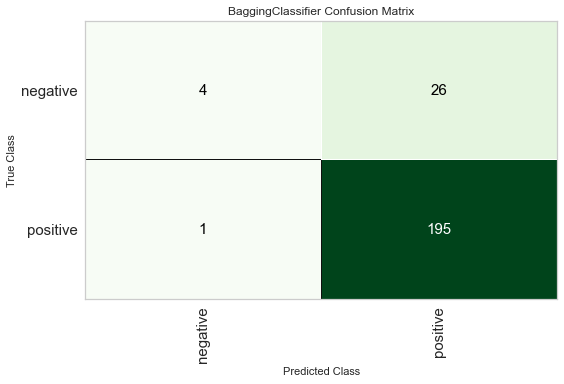

In [24]:
plot_model(best_model, plot="confusion_matrix")

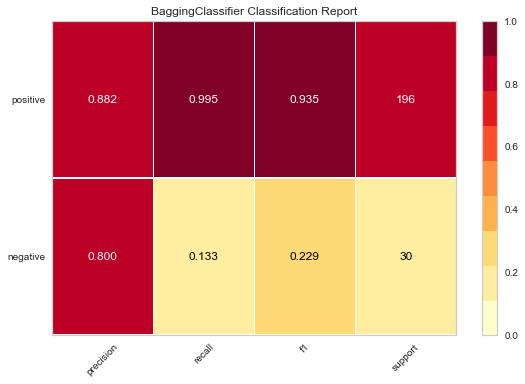

In [25]:
plot_model(best_model, plot="class_report")

In [26]:
final_model = finalize_model(best_model)

In [27]:
predict_model(final_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9558,0.9995,1.0000,0.9515,0.9751,0.7762,0.7964


In [ ]:
final_model.predict(new_test_df)

In [29]:
predict_unseen = predict_model(final_model, data=new_test_df);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0,0.6904,0,0,0,0,0


In [161]:
predict_unseen

,abagnale,able,about,action,actually,after,again,against,ago,all,...,year,years,yes,yet,you,young,your,derived_ratings,Label,Score
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,positive,positive,0.924
146,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,positive,positive,0.858
477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,positive,positive,0.869
469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,positive,positive,0.856
777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,negative,positive,0.709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,0,0,0,0,0,1,0,0,0,3,...,0,0,0,0,0,0,0,positive,positive,0.793
792,0,1,3,0,1,0,0,0,0,4,...,0,1,0,0,1,0,0,positive,positive,0.615
842,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,negative,positive,0.833
396,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,positive,positive,0.783


In [30]:
save_model(final_model,"deployment_04112022")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['19th', '20th',
                                                           'abagnale', 'able',
                                                           'about', 'absolutely',
                                                           'academy', 'account',
                                                           'action', 'actual',
                                                           'actually',
                                                           'adventure', 'after',
                                                           'again', 'against',
                                                        

In [31]:
columns_name = list(new_train_df.columns)
columns_name

['19th',
 '20th',
 'abagnale',
 'able',
 'about',
 'absolutely',
 'academy',
 'account',
 'action',
 'actual',
 'actually',
 'adventure',
 'after',
 'again',
 'against',
 'age',
 'ago',
 'all',
 'allison',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'amazing',
 'american',
 'amount',
 'an',
 'and',
 'anita',
 'another',
 'any',
 'anyone',
 'anything',
 'are',
 'argeneau',
 'around',
 'articles',
 'as',
 'at',
 'attention',
 'author',
 'authors',
 'available',
 'away',
 'back',
 'bad',
 'bank',
 'based',
 'battle',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'bed',
 'been',
 'before',
 'begin',
 'beginning',
 'begins',
 'behind',
 'being',
 'believe',
 'bennie',
 'best',
 'better',
 'between',
 'big',
 'birthday',
 'bit',
 'bite',
 'black',
 'bliss',
 'blood',
 'book',
 'books',
 'boring',
 'both',
 'bought',
 'bourgeoisie',
 'brennan',
 'brief',
 'bring',
 'business',
 'but',
 'buy',
 'by',
 'call',
 'came',
 'can',
 'cannot',
 'capital

In [35]:
new_predict_df= pd.DataFrame(columns=['19th',
 '20th',
 'abagnale',
 'able',
 'about',
 'absolutely',
 'academy',
 'account',
 'action',
 'actual',
 'actually',
 'adventure',
 'after',
 'again',
 'against',
 'age',
 'ago',
 'all',
 'allison',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'amazing',
 'american',
 'amount',
 'an',
 'and',
 'anita',
 'another',
 'any',
 'anyone',
 'anything',
 'are',
 'argeneau',
 'around',
 'articles',
 'as',
 'at',
 'attention',
 'author',
 'authors',
 'available',
 'away',
 'back',
 'bad',
 'bank',
 'based',
 'battle',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'bed',
 'been',
 'before',
 'begin',
 'beginning',
 'begins',
 'behind',
 'being',
 'believe',
 'bennie',
 'best',
 'better',
 'between',
 'big',
 'birthday',
 'bit',
 'bite',
 'black',
 'bliss',
 'blood',
 'book',
 'books',
 'boring',
 'both',
 'bought',
 'bourgeoisie',
 'brennan',
 'brief',
 'bring',
 'business',
 'but',
 'buy',
 'by',
 'call',
 'came',
 'can',
 'cannot',
 'capital',
 'capitalism',
 'capitalist',
 'care',
 'carrie',
 'case',
 'catch',
 'cause',
 'century',
 'certainly',
 'chance',
 'chandler',
 'change',
 'chapter',
 'chapters',
 'character',
 'characters',
 'child',
 'children',
 'civil',
 'class',
 'classes',
 'clear',
 'clearly',
 'cm_cr_arp_d_rvw_txt',
 'collection',
 'college',
 'come',
 'comes',
 'coming',
 'communism',
 'communist',
 'compelling',
 'complete',
 'completely',
 'con',
 'concept',
 'content',
 'control',
 'copy',
 'could',
 'couldn',
 'country',
 'couple',
 'course',
 'cover',
 'created',
 'crime',
 'critique',
 'culture',
 'danger',
 'dark',
 'data',
 'daughter',
 'day',
 'days',
 'dead',
 'deal',
 'death',
 'decided',
 'definitely',
 'descriptions',
 'despite',
 'detail',
 'details',
 'detective',
 'developed',
 'development',
 'dialogue',
 'did',
 'didn',
 'diet',
 'different',
 'difficult',
 'disappointed',
 'division',
 'do',
 'does',
 'doesn',
 'doing',
 'don',
 'done',
 'down',
 'dp',
 'dr',
 'due',
 'during',
 'each',
 'earlier',
 'early',
 'easily',
 'easy',
 'economic',
 'economics',
 'edition',
 'either',
 'else',
 'emily',
 'end',
 'ending',
 'engels',
 'engine',
 'enjoy',
 'enjoyable',
 'enjoyed',
 'enough',
 'entertaining',
 'entire',
 'equal',
 'era',
 'especially',
 'essay',
 'etc',
 'etna',
 'european',
 'even',
 'events',
 'eventually',
 'ever',
 'every',
 'everyone',
 'everything',
 'evil',
 'exactly',
 'example',
 'excellent',
 'except',
 'exciting',
 'existence',
 'existing',
 'expect',
 'expected',
 'experience',
 'face',
 'fact',
 'fall',
 'family',
 'fan',
 'far',
 'fast',
 'father',
 'favorite',
 'fbi',
 'feel',
 'feeling',
 'feels',
 'felt',
 'female',
 'fett',
 'few',
 'fiction',
 'figure',
 'finally',
 'find',
 'finds',
 'finish',
 'finished',
 'fire',
 'first',
 'five',
 'follow',
 'following',
 'food',
 'for',
 'force',
 'forced',
 'forward',
 'found',
 'four',
 'frank',
 'franklin',
 'free',
 'friends',
 'from',
 'full',
 'fully',
 'fun',
 'funny',
 'further',
 'future',
 'gave',
 'general',
 'genre',
 'get',
 'gets',
 'getting',
 'give',
 'given',
 'gives',
 'giving',
 'glad',
 'glycemic',
 'go',
 'god',
 'goes',
 'going',
 'good',
 'got',
 'government',
 'great',
 'greg',
 'group',
 'guy',
 'had',
 'half',
 'hand',
 'happened',
 'happy',
 'hard',
 'has',
 'have',
 'having',
 'he',
 'help',
 'her',
 'here',
 'herself',
 'hicks',
 'high',
 'higher',
 'highly',
 'him',
 'himself',
 'his',
 'historical',
 'history',
 'hold',
 'home',
 'hook',
 'hope',
 'house',
 'how',
 'however',
 'href',
 'human',
 'husband',
 'idea',
 'ideas',
 'ie',
 'if',
 'immediately',
 'important',
 'in',
 'industrial',
 'information',
 'instead',
 'interest',
 'interested',
 'interesting',
 'into',
 'intriguing',
 'introduced',
 'introduction',
 'involved',
 'is',
 'isn',
 'issues',
 'it',
 'its',
 'itself',
 'jack',
 'jane',
 'jedi',
 'job',
 'judy',
 'julia',
 'just',
 'justice',
 'karl',
 'keep',
 'kept',
 'kill',
 'killed',
 'killing',
 'kincaid',
 'kind',
 'kindle',
 'knew',
 'know',
 'known',
 'ky',
 'labor',
 'language',
 'large',
 'last',
 'later',
 'law',
 'lead',
 'learn',
 'least',
 'leave',
 'left',
 'less',
 'let',
 'life',
 'light',
 'like',
 'liked',
 'line',
 'link',
 'linked',
 'lisa',
 'lissi',
 'lissianna',
 'list',
 'little',
 'live',
 'lives',
 'living',
 'll',
 'load',
 'local',
 'long',
 'longer',
 'look',
 'looking',
 'looks',
 'lost',
 'lot',
 'love',
 'loved',
 'low',
 'lynsay',
 'machinery',
 'machines',
 'made',
 'main',
 'major',
 'make',
 'makes',
 'making',
 'man',
 'manifesto',
 'manufactured',
 'many',
 'market',
 'marlowe',
 'marriage',
 'marx',
 'master',
 'matter',
 'may',
 'maybe',
 'mayes',
 'mcgavock',
 'me',
 'mean',
 'means',
 'men',
 'mentioned',
 'middle',
 'might',
 'military',
 'mill',
 'mind',
 'missing',
 'modern',
 'money',
 'moon',
 'more',
 'most',
 'mother',
 'movie',
 'mr',
 'ms',
 'much',
 'murder',
 'must',
 'my',
 'myself',
 'mystery',
 'name',
 'near',
 'necessary',
 'need',
 'needed',
 'needs',
 'never',
 'new',
 'news',
 'newspaper',
 'next',
 'nice',
 'nicholas',
 'night',
 'no',
 'normal',
 'not',
 'nothing',
 'novel',
 'novels',
 'now',
 'number',
 'observation',
 'obsession',
 'of',
 'off',
 'often',
 'ok',
 'old',
 'on',
 'once',
 'one',
 'ones',
 'only',
 'or',
 'order',
 'original',
 'other',
 'others',
 'otherwise',
 'our',
 'out',
 'over',
 'overall',
 'own',
 'page',
 'pages',
 'paper',
 'paranormal',
 'part',
 'particular',
 'particularly',
 'parts',
 'passion',
 'past',
 'people',
 'perfect',
 'perhaps',
 'person',
 'personal',
 'philosophy',
 'pick',
 'pigeon',
 'place',
 'places',
 'plot',
 'point',
 'political',
 'poor',
 'possible',
 'post',
 'power',
 'present',
 'presented',
 'pretty',
 'previous',
 'price',
 'prison',
 'private',
 'probably',
 'problem',
 'problems',
 'product',
 'production',
 'productive',
 'professor',
 'proletariat',
 'property',
 'published',
 'put',
 'questions',
 'quick',
 'quickly',
 'quite',
 'rate',
 'rates',
 'rather',
 'rating',
 're',
 'read',
 'reader',
 'readers',
 'reading',
 'real',
 'reality',
 'really',
 'reason',
 'reasons',
 'recommend',
 'ref',
 'relations',
 'relationship',
 'rest',
 'return',
 'review',
 'reviews',
 'revolution',
 'rich',
 'right',
 'romance',
 'romantic',
 'rosato',
 'said',
 'same',
 'sands',
 'save',
 'saved',
 'say',
 'saying',
 'says',
 'scenes',
 'scottoline',
 'second',
 'section',
 'see',
 'seem',
 'seemed',
 'seems',
 'seen',
 'self',
 'sense',
 'series',
 'set',
 'several',
 'sex',
 'she',
 'ship',
 'short',
 'should',
 'shreve',
 'side',
 'sight',
 'simple',
 'simply',
 'since',
 'sister',
 'slave',
 'slow',
 'small',
 'so',
 'social',
 'society',
 'some',
 'someone',
 'something',
 'sometimes',
 'somewhat',
 'sort',
 'source',
 'south',
 'sowell',
 'space',
 'speak',
 'spoilers',
 'stand',
 'star',
 'stars',
 'start',
 'started',
 'starts',
 'state',
 'states',
 'steam',
 'still',
 'stories',
 'story',
 'strong',
 'style',
 'subject',
 'subscription',
 'such',
 'sure',
 'suspense',
 'system',
 'take',
 'takes',
 'taking',
 'tale',
 'tassel',
 'tell',
 'tells',
 'text',
 'than',
 'thanks',
 'that',
 'the',
 'their',
 'them',
 'themselves',
 'then',
 'there',
 'these',
 'they',
 'thing',
 'things',
 'think',
 'thinking',
 'this',
 'thomas',
 'those',
 'though',
 'thought',
 'three',
 'through',
 'throughout',
 'thus',
 'tied',
 'time',
 'times',
 'to',
 'today',
 'together',
 'told',
 'tony',
 'too',
 'took',
 'trading',
 'travel',
 'trial',
 'tribe',
 'trilogy',
 'true',
 'truly',
 'try',
 'trying',
 'turn',
 'turns',
 'twist',
 'two',
 'ultimately',
 'under',
 'understand',
 'understanding',
 'unfortunately',
 'unique',
 'until',
 'up',
 'upon',
 'us',
 'use',
 'used',
 'usually',
 'utf8',
 'value',
 'vampire',
 'vampires',
 'van',
 'various',
 'vatta',
 've',
 'version',
 'very',
 'view',
 'villain',
 'volume',
 'vong',
 'wait',
 'want',
 'wanted',
 'wants',
 'war',
 'was',
 'wasn',
 'way',
 'ways',
 'we',
 'wealth',
 'weight',
 'well',
 'went',
 'were',
 'what',
 'when',
 'where',
 'whether',
 'which',
 'while',
 'who',
 'whole',
 'whose',
 'why',
 'wife',
 'will',
 'wish',
 'with',
 'within',
 'without',
 'woman',
 'women',
 'won',
 'wonderful',
 'word',
 'words',
 'work',
 'workers',
 'working',
 'works',
 'world',
 'worth',
 'would',
 'write',
 'writer',
 'writes',
 'writing',
 'written',
 'wrong',
 'wrote',
 'year',
 'years',
 'yes',
 'yet',
 'you',
 'young',
 'your',
 'derived_ratings'])

In [36]:
new_predict_df

,19th,20th,abagnale,able,about,absolutely,academy,account,action,actual,...,wrong,wrote,year,years,yes,yet,you,young,your,derived_ratings


In [37]:
model = load_model('deployment_04112022')

Transformation Pipeline and Model Successfully Loaded


In [71]:
cols = ['reviewText']
records = [['very bad lenghty very bad problem boring very bad lenghty very bad problem boring very bad lenghty very bad problem boring']]
input_df = pd.DataFrame(data=records,columns=cols)

In [72]:
tf_vectorizer = CountVectorizer()
features = tf_vectorizer.fit_transform(input_df['reviewText'].apply(lambda features : np.str_(features)))
features_df = pd.DataFrame(features.toarray(), columns=tf_vectorizer.get_feature_names())

In [73]:
features_df

,bad,boring,lenghty,problem,very
0,6,3,3,3,6


In [74]:
dummy = new_predict_df.head(1)
dummy[dummy > 0] = 0
dummy

,19th,20th,abagnale,able,about,absolutely,academy,account,action,actual,actually,adventure,after,again,against,age,ago,all,allison,almost,alone,along,already,also,although,always,am,amazing,american,amount,an,and,anita,another,any,anyone,anything,are,argeneau,around,articles,as,at,attention,author,authors,available,away,back,bad,bank,based,battle,be,became,because,become,becomes,bed,been,before,begin,beginning,begins,behind,being,believe,bennie,best,better,between,big,birthday,bit,bite,black,bliss,blood,book,books,boring,both,bought,bourgeoisie,brennan,brief,bring,business,but,buy,by,call,came,can,cannot,capital,capitalism,capitalist,care,carrie,case,catch,cause,century,certainly,chance,chandler,change,chapter,chapters,character,characters,child,children,civil,class,classes,clear,clearly,cm_cr_arp_d_rvw_txt,collection,college,come,comes,coming,communism,communist,compelling,complete,completely,con,concept,content,control,copy,could,couldn,country,couple,course,cover,created,crime,critique,culture,danger,dark,data,daughter,day,days,dead,deal,death,decided,definitely,descriptions,despite,detail,details,detective,developed,development,dialogue,did,didn,diet,different,difficult,disappointed,division,do,does,doesn,doing,don,done,down,dp,dr,due,during,each,earlier,early,easily,easy,economic,economics,edition,either,else,emily,end,ending,engels,engine,enjoy,enjoyable,enjoyed,enough,entertaining,entire,equal,era,especially,essay,etc,etna,european,even,events,eventually,ever,every,everyone,everything,evil,exactly,example,excellent,except,exciting,existence,existing,expect,expected,experience,face,fact,fall,family,fan,far,fast,father,favorite,fbi,feel,feeling,feels,felt,female,fett,few,fiction,figure,finally,find,finds,finish,finished,fire,first,five,follow,following,food,for,force,forced,forward,found,four,frank,franklin,free,friends,from,full,fully,fun,funny,further,future,gave,general,genre,get,gets,getting,give,given,gives,giving,glad,glycemic,go,god,goes,going,good,got,government,great,greg,group,guy,had,half,hand,happened,happy,hard,has,have,having,he,help,her,here,herself,hicks,high,higher,highly,him,himself,his,historical,history,hold,home,hook,hope,house,how,however,href,human,husband,idea,ideas,ie,if,immediately,important,in,industrial,information,instead,interest,interested,interesting,into,intriguing,introduced,introduction,involved,is,isn,issues,it,its,itself,jack,jane,jedi,job,judy,julia,just,justice,karl,keep,kept,kill,killed,killing,kincaid,kind,kindle,knew,know,known,ky,labor,language,large,last,later,law,lead,learn,least,leave,left,less,let,life,light,like,liked,line,link,linked,lisa,lissi,lissianna,list,little,live,lives,living,ll,load,local,long,longer,look,looking,looks,lost,lot,love,loved,low,lynsay,machinery,machines,made,main,major,make,makes,making,man,manifesto,manufactured,many,market,marlowe,marriage,marx,master,matter,may,maybe,mayes,mcgavock,me,mean,means,men,mentioned,middle,might,military,mill,mind,missing,modern,money,moon,more,most,mother,movie,mr,ms,much,murder,must,my,myself,mystery,name,near,necessary,need,needed,needs,never,new,news,newspaper,next,nice,nicholas,night,no,normal,not,nothing,novel,novels,now,number,observation,obsession,of,off,often,ok,old,on,once,one,ones,only,or,order,original,other,others,otherwise,our,out,over,overall,own,page,pages,paper,paranormal,part,particular,particularly,parts,passion,past,people,perfect,perhaps,person,personal,philosophy,pick,pigeon,place,places,plot,point,political,poor,possible,post,power,present,presented,pretty,previous,price,prison,private,probably,problem,problems,product,production,productive,professor,proletariat,property,published,put,questions,quick,quickly,quite,rate,rates,rather,rating,re,read,reader,readers,reading,real,reality,really,reason,reasons,recommend,ref,relations,relationship,rest,return,review,reviews,revolution,rich,right,romance,romantic,rosato,said,same,sands,save,saved,say,saying,says,scenes,scottoline,second,section,see,seem,see

In [75]:
for col in dummy:
    try:
        dummy[col] = features_df[col]
    except:
        pass


In [76]:
dummy.head(1)


,19th,20th,abagnale,able,about,absolutely,academy,account,action,actual,actually,adventure,after,again,against,age,ago,all,allison,almost,alone,along,already,also,although,always,am,amazing,american,amount,an,and,anita,another,any,anyone,anything,are,argeneau,around,articles,as,at,attention,author,authors,available,away,back,bad,bank,based,battle,be,became,because,become,becomes,bed,been,before,begin,beginning,begins,behind,being,believe,bennie,best,better,between,big,birthday,bit,bite,black,bliss,blood,book,books,boring,both,bought,bourgeoisie,brennan,brief,bring,business,but,buy,by,call,came,can,cannot,capital,capitalism,capitalist,care,carrie,case,catch,cause,century,certainly,chance,chandler,change,chapter,chapters,character,characters,child,children,civil,class,classes,clear,clearly,cm_cr_arp_d_rvw_txt,collection,college,come,comes,coming,communism,communist,compelling,complete,completely,con,concept,content,control,copy,could,couldn,country,couple,course,cover,created,crime,critique,culture,danger,dark,data,daughter,day,days,dead,deal,death,decided,definitely,descriptions,despite,detail,details,detective,developed,development,dialogue,did,didn,diet,different,difficult,disappointed,division,do,does,doesn,doing,don,done,down,dp,dr,due,during,each,earlier,early,easily,easy,economic,economics,edition,either,else,emily,end,ending,engels,engine,enjoy,enjoyable,enjoyed,enough,entertaining,entire,equal,era,especially,essay,etc,etna,european,even,events,eventually,ever,every,everyone,everything,evil,exactly,example,excellent,except,exciting,existence,existing,expect,expected,experience,face,fact,fall,family,fan,far,fast,father,favorite,fbi,feel,feeling,feels,felt,female,fett,few,fiction,figure,finally,find,finds,finish,finished,fire,first,five,follow,following,food,for,force,forced,forward,found,four,frank,franklin,free,friends,from,full,fully,fun,funny,further,future,gave,general,genre,get,gets,getting,give,given,gives,giving,glad,glycemic,go,god,goes,going,good,got,government,great,greg,group,guy,had,half,hand,happened,happy,hard,has,have,having,he,help,her,here,herself,hicks,high,higher,highly,him,himself,his,historical,history,hold,home,hook,hope,house,how,however,href,human,husband,idea,ideas,ie,if,immediately,important,in,industrial,information,instead,interest,interested,interesting,into,intriguing,introduced,introduction,involved,is,isn,issues,it,its,itself,jack,jane,jedi,job,judy,julia,just,justice,karl,keep,kept,kill,killed,killing,kincaid,kind,kindle,knew,know,known,ky,labor,language,large,last,later,law,lead,learn,least,leave,left,less,let,life,light,like,liked,line,link,linked,lisa,lissi,lissianna,list,little,live,lives,living,ll,load,local,long,longer,look,looking,looks,lost,lot,love,loved,low,lynsay,machinery,machines,made,main,major,make,makes,making,man,manifesto,manufactured,many,market,marlowe,marriage,marx,master,matter,may,maybe,mayes,mcgavock,me,mean,means,men,mentioned,middle,might,military,mill,mind,missing,modern,money,moon,more,most,mother,movie,mr,ms,much,murder,must,my,myself,mystery,name,near,necessary,need,needed,needs,never,new,news,newspaper,next,nice,nicholas,night,no,normal,not,nothing,novel,novels,now,number,observation,obsession,of,off,often,ok,old,on,once,one,ones,only,or,order,original,other,others,otherwise,our,out,over,overall,own,page,pages,paper,paranormal,part,particular,particularly,parts,passion,past,people,perfect,perhaps,person,personal,philosophy,pick,pigeon,place,places,plot,point,political,poor,possible,post,power,present,presented,pretty,previous,price,prison,private,probably,problem,problems,product,production,productive,professor,proletariat,property,published,put,questions,quick,quickly,quite,rate,rates,rather,rating,re,read,reader,readers,reading,real,reality,really,reason,reasons,recommend,ref,relations,relationship,rest,return,review,reviews,revolution,rich,right,romance,romantic,rosato,said,same,sands,save,saved,say,saying,says,scenes,scottoline,second,section,see,seem,see

In [77]:
predict_df = dummy.fillna(0)

In [78]:
predict_df

,19th,20th,abagnale,able,about,absolutely,academy,account,action,actual,actually,adventure,after,again,against,age,ago,all,allison,almost,alone,along,already,also,although,always,am,amazing,american,amount,an,and,anita,another,any,anyone,anything,are,argeneau,around,articles,as,at,attention,author,authors,available,away,back,bad,bank,based,battle,be,became,because,become,becomes,bed,been,before,begin,beginning,begins,behind,being,believe,bennie,best,better,between,big,birthday,bit,bite,black,bliss,blood,book,books,boring,both,bought,bourgeoisie,brennan,brief,bring,business,but,buy,by,call,came,can,cannot,capital,capitalism,capitalist,care,carrie,case,catch,cause,century,certainly,chance,chandler,change,chapter,chapters,character,characters,child,children,civil,class,classes,clear,clearly,cm_cr_arp_d_rvw_txt,collection,college,come,comes,coming,communism,communist,compelling,complete,completely,con,concept,content,control,copy,could,couldn,country,couple,course,cover,created,crime,critique,culture,danger,dark,data,daughter,day,days,dead,deal,death,decided,definitely,descriptions,despite,detail,details,detective,developed,development,dialogue,did,didn,diet,different,difficult,disappointed,division,do,does,doesn,doing,don,done,down,dp,dr,due,during,each,earlier,early,easily,easy,economic,economics,edition,either,else,emily,end,ending,engels,engine,enjoy,enjoyable,enjoyed,enough,entertaining,entire,equal,era,especially,essay,etc,etna,european,even,events,eventually,ever,every,everyone,everything,evil,exactly,example,excellent,except,exciting,existence,existing,expect,expected,experience,face,fact,fall,family,fan,far,fast,father,favorite,fbi,feel,feeling,feels,felt,female,fett,few,fiction,figure,finally,find,finds,finish,finished,fire,first,five,follow,following,food,for,force,forced,forward,found,four,frank,franklin,free,friends,from,full,fully,fun,funny,further,future,gave,general,genre,get,gets,getting,give,given,gives,giving,glad,glycemic,go,god,goes,going,good,got,government,great,greg,group,guy,had,half,hand,happened,happy,hard,has,have,having,he,help,her,here,herself,hicks,high,higher,highly,him,himself,his,historical,history,hold,home,hook,hope,house,how,however,href,human,husband,idea,ideas,ie,if,immediately,important,in,industrial,information,instead,interest,interested,interesting,into,intriguing,introduced,introduction,involved,is,isn,issues,it,its,itself,jack,jane,jedi,job,judy,julia,just,justice,karl,keep,kept,kill,killed,killing,kincaid,kind,kindle,knew,know,known,ky,labor,language,large,last,later,law,lead,learn,least,leave,left,less,let,life,light,like,liked,line,link,linked,lisa,lissi,lissianna,list,little,live,lives,living,ll,load,local,long,longer,look,looking,looks,lost,lot,love,loved,low,lynsay,machinery,machines,made,main,major,make,makes,making,man,manifesto,manufactured,many,market,marlowe,marriage,marx,master,matter,may,maybe,mayes,mcgavock,me,mean,means,men,mentioned,middle,might,military,mill,mind,missing,modern,money,moon,more,most,mother,movie,mr,ms,much,murder,must,my,myself,mystery,name,near,necessary,need,needed,needs,never,new,news,newspaper,next,nice,nicholas,night,no,normal,not,nothing,novel,novels,now,number,observation,obsession,of,off,often,ok,old,on,once,one,ones,only,or,order,original,other,others,otherwise,our,out,over,overall,own,page,pages,paper,paranormal,part,particular,particularly,parts,passion,past,people,perfect,perhaps,person,personal,philosophy,pick,pigeon,place,places,plot,point,political,poor,possible,post,power,present,presented,pretty,previous,price,prison,private,probably,problem,problems,product,production,productive,professor,proletariat,property,published,put,questions,quick,quickly,quite,rate,rates,rather,rating,re,read,reader,readers,reading,real,reality,really,reason,reasons,recommend,ref,relations,relationship,rest,return,review,reviews,revolution,rich,right,romance,romantic,rosato,said,same,sands,save,saved,say,saying,says,scenes,scottoline,second,section,see,seem,see

In [79]:
pd.set_option('display.max_columns', 805)

In [80]:
predict_df

,19th,20th,abagnale,able,about,absolutely,academy,account,action,actual,actually,adventure,after,again,against,age,ago,all,allison,almost,alone,along,already,also,although,always,am,amazing,american,amount,an,and,anita,another,any,anyone,anything,are,argeneau,around,articles,as,at,attention,author,authors,available,away,back,bad,bank,based,battle,be,became,because,become,becomes,bed,been,before,begin,beginning,begins,behind,being,believe,bennie,best,better,between,big,birthday,bit,bite,black,bliss,blood,book,books,boring,both,bought,bourgeoisie,brennan,brief,bring,business,but,buy,by,call,came,can,cannot,capital,capitalism,capitalist,care,carrie,case,catch,cause,century,certainly,chance,chandler,change,chapter,chapters,character,characters,child,children,civil,class,classes,clear,clearly,cm_cr_arp_d_rvw_txt,collection,college,come,comes,coming,communism,communist,compelling,complete,completely,con,concept,content,control,copy,could,couldn,country,couple,course,cover,created,crime,critique,culture,danger,dark,data,daughter,day,days,dead,deal,death,decided,definitely,descriptions,despite,detail,details,detective,developed,development,dialogue,did,didn,diet,different,difficult,disappointed,division,do,does,doesn,doing,don,done,down,dp,dr,due,during,each,earlier,early,easily,easy,economic,economics,edition,either,else,emily,end,ending,engels,engine,enjoy,enjoyable,enjoyed,enough,entertaining,entire,equal,era,especially,essay,etc,etna,european,even,events,eventually,ever,every,everyone,everything,evil,exactly,example,excellent,except,exciting,existence,existing,expect,expected,experience,face,fact,fall,family,fan,far,fast,father,favorite,fbi,feel,feeling,feels,felt,female,fett,few,fiction,figure,finally,find,finds,finish,finished,fire,first,five,follow,following,food,for,force,forced,forward,found,four,frank,franklin,free,friends,from,full,fully,fun,funny,further,future,gave,general,genre,get,gets,getting,give,given,gives,giving,glad,glycemic,go,god,goes,going,good,got,government,great,greg,group,guy,had,half,hand,happened,happy,hard,has,have,having,he,help,her,here,herself,hicks,high,higher,highly,him,himself,his,historical,history,hold,home,hook,hope,house,how,however,href,human,husband,idea,ideas,ie,if,immediately,important,in,industrial,information,instead,interest,interested,interesting,into,intriguing,introduced,introduction,involved,is,isn,issues,it,its,itself,jack,jane,jedi,job,judy,julia,just,justice,karl,keep,kept,kill,killed,killing,kincaid,kind,kindle,knew,know,known,ky,labor,language,large,last,later,law,lead,learn,least,leave,left,less,let,life,light,like,liked,line,link,linked,lisa,lissi,lissianna,list,little,live,lives,living,ll,load,local,long,longer,look,looking,looks,lost,lot,love,loved,low,lynsay,machinery,machines,made,main,major,make,makes,making,man,manifesto,manufactured,many,market,marlowe,marriage,marx,master,matter,may,maybe,mayes,mcgavock,me,mean,means,men,mentioned,middle,might,military,mill,mind,missing,modern,money,moon,more,most,mother,movie,mr,ms,much,murder,must,my,myself,mystery,name,near,necessary,need,needed,needs,never,new,news,newspaper,next,nice,nicholas,night,no,normal,not,nothing,novel,novels,now,number,observation,obsession,of,off,often,ok,old,on,once,one,ones,only,or,order,original,other,others,otherwise,our,out,over,overall,own,page,pages,paper,paranormal,part,particular,particularly,parts,passion,past,people,perfect,perhaps,person,personal,philosophy,pick,pigeon,place,places,plot,point,political,poor,possible,post,power,present,presented,pretty,previous,price,prison,private,probably,problem,problems,product,production,productive,professor,proletariat,property,published,put,questions,quick,quickly,quite,rate,rates,rather,rating,re,read,reader,readers,reading,real,reality,really,reason,reasons,recommend,ref,relations,relationship,rest,return,review,reviews,revolution,rich,right,romance,romantic,rosato,said,same,sands,save,saved,say,saying,says,scenes,scottoline,second,section,see,seem,see

In [81]:
prediction =predict_model(model,data=predict_df,round=0)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,1,0,0,0,0,nan,0


In [82]:
prediction

,19th,20th,abagnale,able,about,absolutely,academy,account,action,actual,actually,adventure,after,again,against,age,ago,all,allison,almost,alone,along,already,also,although,always,am,amazing,american,amount,an,and,anita,another,any,anyone,anything,are,argeneau,around,articles,as,at,attention,author,authors,available,away,back,bad,bank,based,battle,be,became,because,become,becomes,bed,been,before,begin,beginning,begins,behind,being,believe,bennie,best,better,between,big,birthday,bit,bite,black,bliss,blood,book,books,boring,both,bought,bourgeoisie,brennan,brief,bring,business,but,buy,by,call,came,can,cannot,capital,capitalism,capitalist,care,carrie,case,catch,cause,century,certainly,chance,chandler,change,chapter,chapters,character,characters,child,children,civil,class,classes,clear,clearly,cm_cr_arp_d_rvw_txt,collection,college,come,comes,coming,communism,communist,compelling,complete,completely,con,concept,content,control,copy,could,couldn,country,couple,course,cover,created,crime,critique,culture,danger,dark,data,daughter,day,days,dead,deal,death,decided,definitely,descriptions,despite,detail,details,detective,developed,development,dialogue,did,didn,diet,different,difficult,disappointed,division,do,does,doesn,doing,don,done,down,dp,dr,due,during,each,earlier,early,easily,easy,economic,economics,edition,either,else,emily,end,ending,engels,engine,enjoy,enjoyable,enjoyed,enough,entertaining,entire,equal,era,especially,essay,etc,etna,european,even,events,eventually,ever,every,everyone,everything,evil,exactly,example,excellent,except,exciting,existence,existing,expect,expected,experience,face,fact,fall,family,fan,far,fast,father,favorite,fbi,feel,feeling,feels,felt,female,fett,few,fiction,figure,finally,find,finds,finish,finished,fire,first,five,follow,following,food,for,force,forced,forward,found,four,frank,franklin,free,friends,from,full,fully,fun,funny,further,future,gave,general,genre,get,gets,getting,give,given,gives,giving,glad,glycemic,go,god,goes,going,good,got,government,great,greg,group,guy,had,half,hand,happened,happy,hard,has,have,having,he,help,her,here,herself,hicks,high,higher,highly,him,himself,his,historical,history,hold,home,hook,hope,house,how,however,href,human,husband,idea,ideas,ie,if,immediately,important,in,industrial,information,instead,interest,interested,interesting,into,intriguing,introduced,introduction,involved,is,isn,issues,it,its,itself,jack,jane,jedi,job,judy,julia,just,justice,karl,keep,kept,kill,killed,killing,kincaid,kind,kindle,knew,know,known,ky,labor,language,large,last,later,law,lead,learn,least,leave,left,less,let,life,light,like,liked,line,link,linked,lisa,lissi,lissianna,list,little,live,lives,living,ll,load,local,long,longer,look,looking,looks,lost,lot,love,loved,low,lynsay,machinery,machines,made,main,major,make,makes,making,man,manifesto,manufactured,many,market,marlowe,marriage,marx,master,matter,may,maybe,mayes,mcgavock,me,mean,means,men,mentioned,middle,might,military,mill,mind,missing,modern,money,moon,more,most,mother,movie,mr,ms,much,murder,must,my,myself,mystery,name,near,necessary,need,needed,needs,never,new,news,newspaper,next,nice,nicholas,night,no,normal,not,nothing,novel,novels,now,number,observation,obsession,of,off,often,ok,old,on,once,one,ones,only,or,order,original,other,others,otherwise,our,out,over,overall,own,page,pages,paper,paranormal,part,particular,particularly,parts,passion,past,people,perfect,perhaps,person,personal,philosophy,pick,pigeon,place,places,plot,point,political,poor,possible,post,power,present,presented,pretty,previous,price,prison,private,probably,problem,problems,product,production,productive,professor,proletariat,property,published,put,questions,quick,quickly,quite,rate,rates,rather,rating,re,read,reader,readers,reading,real,reality,really,reason,reasons,recommend,ref,relations,relationship,rest,return,review,reviews,revolution,rich,right,romance,romantic,rosato,said,same,sands,save,saved,say,saying,says,scenes,scottoline,second,section,see,seem,see

In [84]:
p1=model.predict(predict_df)

In [85]:
p1[0]

0

In [86]:
type(p1[0])

numpy.int64

In [87]:
prediction = prediction.Label[0]

In [88]:
prediction

'negative'

In [178]:
get_config('seed')

6843